In [2]:
from PIL import Image
import numpy as np
import os
import keras
from keras import ops
from keras import layers
from keras import models
from keras import regularizers

import pprint
import matplotlib.pyplot as plt
import skimage as ski

# Data Preprocessing #
### Resize Signatures ###

In [2]:
def resize_images(input_dir, output_dir, width, height):
    for filename in os.listdir(input_dir):
        img_path = os.path.join(input_dir, filename)
        try:
            with Image.open(img_path) as img:
                resized = img.resize((width, height), Image.BILINEAR)
                resized.save(os.path.join(output_dir, filename))
        except Exception as e:
            print(f"Could not process {filename}: {e}")


In [3]:
notebook_dir = os.getcwd()
resize_images(os.path.join(notebook_dir, "signatures/full_forg"), os.path.join(notebook_dir, "signatures/resized_forg"), 220, 155)

Could not process .DS_Store: cannot identify image file 'c:\\Users\\falco\\OneDrive\\Desktop\\Hamilton\\Sem62025Spring\\ArtificialNeuralNetworks\\FinalProject\\signatures/full_forg\\.DS_Store'


### Clean Resized Data ###

In [ ]:
FORG_DATA_PATH = "signatures/resized_forg"
ORG_DATA_PATH = "signatures/resized_org"


'''
For each image, 
    converts to black and white, 
    turns into an np array, and 
    stores it in dict as:
        forgeries[IMAGE_NAME]
            or
        originals[IMAGE_NAME]
'''
forgeries = {}
for filename in os.listdir(FORG_DATA_PATH):
    name = filename.split(".")[0]
    filepath = FORG_DATA_PATH + "/" + filename
    with Image.open(filepath) as img:
        # Manual conversion to B&W using otsu thresholding
        greyscale = img.convert('L')
        threshold = ski.filters.threshold_otsu(np.asarray(greyscale))
        thresholded = greyscale.point( lambda p: 255 if p > threshold else 0 )
        black_and_white = thresholded.convert('1')  

        forgeries[name] = np.array(black_and_white)

originals = {}
for filename in os.listdir(ORG_DATA_PATH):
    name = filename.split(".")[0]
    filepath = ORG_DATA_PATH + "/" + filename
    with Image.open(filepath) as img:
        # Manual conversion to B&W using otsu thresholding
        greyscale = img.convert('L')
        hreshold = ski.filters.threshold_otsu(np.asarray(greyscale))
        thresholded = greyscale.point( lambda p: 255 if p > threshold else 0 )
        black_and_white = thresholded.convert('1') 

        originals[name] = np.array(black_and_white)

### Format into testing/training data ###

In [5]:
# Reformat into sig_dict[user_id] -> {"originals": {}, "forgeries", {}}

sig_dict = {}

for key in forgeries.keys():
    user_id = key.split("_")[1]
    sig_number = key.split("_")[2]

    if user_id in sig_dict.keys():
        sig_dict[user_id]["forgeries"][sig_number] = forgeries[key]
    else:
        sig_dict[user_id] = {"forgeries" : {sig_number : forgeries[key]},
                             "originals" : {}
                             }

for key in originals.keys():
    user_id = key.split("_")[1]
    sig_number = key.split("_")[2]
    sig_dict[user_id]["originals"][sig_number] = originals[key]
    # sig_dict[user_id]["originals"][sig_number] = "org"

'''    
Current format:
sig_dict = {
    [user number] : { 
            "forgeries" : {"1": [first_forgery],
                           "2": [second_forgery],
                           ...},
            "originals" : "1": [first_original],
                           "2": [second_original],
                           ...}
            }
    "2" : { ...
    }
'''


'    \nCurrent format:\nsig_dict = {\n    [user number] : { \n            "forgeries" : {"1": [first_forgery],\n                           "2": [second_forgery],\n                           ...},\n            "originals" : "1": [first_original],\n                           "2": [second_original],\n                           ...}\n            }\n    "2" : { ...\n    }\n'

In [6]:
x_train, y_train = [], []
x_test, y_test = [], []

# labels: 1 == genuine:genuine, 0 == genuine:forgery
# The first 44 users will be train and the remaining 11 will be in testing

for user_id in sig_dict.keys():
    user_sigs = sig_dict[user_id]

    if int(user_id) <= 44: 
        # TRAINING DATA

        for reference_sig_id in user_sigs["originals"]:
            reference_original = user_sigs["originals"][reference_sig_id]

            # Iterate through all other signatures and make a data point
            # Originals
            for org_id in user_sigs["originals"]:
                if org_id == reference_sig_id: continue
                org_image = user_sigs["originals"][org_id]

                x_train.append((reference_original, org_image))
                y_train.append(1)
            
            # Forgeries
            for forg_id in user_sigs["forgeries"]:
                forg_image = user_sigs["forgeries"][forg_id]

                x_train.append((reference_original, forg_image))
                y_train.append(0)


    else:
        #TESTING
        
        for reference_sig_id in user_sigs["originals"]:
            reference_original = user_sigs["originals"][reference_sig_id]

            # Iterate through all other signatures and make a data point
            # Originals
            for org_id in user_sigs["originals"]:
                if org_id == reference_sig_id: continue
                org_image = user_sigs["originals"][org_id]

                x_test.append((reference_original, org_image))
                y_test.append(1)
            
            # Forgeries
            for forg_id in user_sigs["forgeries"]:
                forg_image = user_sigs["forgeries"][forg_id]

                x_test.append((reference_original, forg_image))
                y_test.append(0)

x_train = np.array(x_train, dtype='float32')
y_train = np.array(y_train, dtype='float32')
x_test = np.array(x_test, dtype='float32')
y_test = np.array(y_test, dtype='float32')
    

In [8]:
x_train_1 = x_train[:, 0]
x_train_2 = x_train[:, 1]

x_test_1 = x_test[:, 0]
x_test_2 = x_test[:, 1]

### Verify Data ###

In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    
    num_row = to_show // num_col if to_show // num_col != 0 else 1
    to_show = num_row * num_col
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(ops.concatenate([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

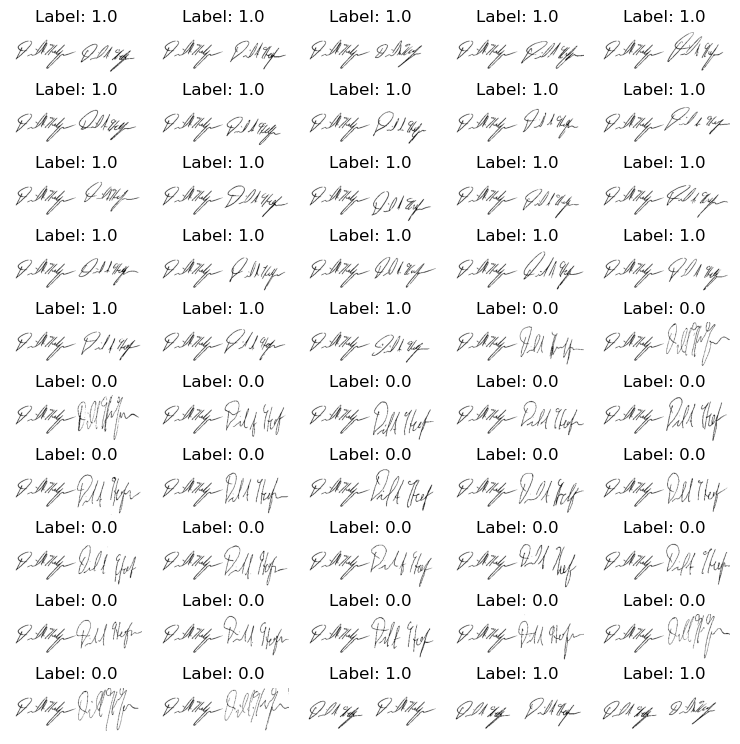

In [10]:
visualize(x_train[:-1], y_train[:-1], to_show=50, num_col=5)

# Model Construction #

In [11]:
def euclidean_dist(vectors):
    x, y = vectors
    return ops.sqrt(ops.maximum(ops.sum(ops.square(x - y), axis=1, keepdims=True), keras.backend.epsilon()))

In [ ]:
def loss(margin=1):
    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        return ops.mean((1 - y_true) * ops.square(y_pred) + (y_true) * ops.square(ops.maximum(margin - (y_pred), 0)))

    return contrastive_loss

In [12]:
base_model = models.Sequential([
    layers.Input((155, 220, 1)),
    layers.Conv2D(96, (11, 11), activation='relu', strides=4, padding='same', kernel_regularizer = "L2"),
    layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
    layers.MaxPooling2D((3,3), strides=(2, 2)),
    layers.ZeroPadding2D((2, 2)),

    layers.Conv2D(256, kernel_size=(5, 5), activation='relu', strides=1, kernel_regularizer = "L2"),
    layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
    layers.MaxPooling2D((3,3), strides=(2, 2)),
    layers.Dropout(0.2),
    layers.ZeroPadding2D((1, 1)),


    layers.Conv2D(384, kernel_size=(3, 3), activation='relu', strides=1, kernel_regularizer = "L2"),
    layers.ZeroPadding2D((1, 1)),

    layers.Conv2D(256, kernel_size=(3, 3), activation='relu', strides=1, kernel_regularizer = "L2"),
    layers.MaxPooling2D((3,3), strides=(2,2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(1028, activation='relu', kernel_regularizer = "L2"),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu', kernel_regularizer = "L2")])

In [ ]:
input_1 = keras.layers.Input((155, 220, 1))
input_2 = keras.layers.Input((155, 220, 1))

siamese_1 = base_model(input_1)
siamese_2 = base_model(input_2)

merge_layer = keras.layers.Lambda(euclidean_dist, output_shape=(1,))([siamese_1, siamese_2])
normalization_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normalization_layer)
siamese_network = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [21]:
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 39, 55, 96)     │        11,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 39, 55, 96)     │           156 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 23, 31, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 19, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 19, 27, 256)    │            76 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 13, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 13, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 11, 15, 256)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 13, 384)     │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 11, 15, 384)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 9, 13, 256)     │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1028)           │     6,317,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       131,712 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,845,484 (33.74 MB)

 Trainable params: 8,845,368 (33.74 MB)

 Non-trainable params: 116 (464.00 B)

In [ ]:
siamese_network.compile(loss=loss(margin=1), optimizer="Adam", metrics=["accuracy"])
siamese_network.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 155, 220,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 155, 220,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │  8,845,484 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,845,490 (33.74 MB)

 Trainable params: 8,845,372 (33.74 MB)

 Non-trainable params: 118 (472.00 B)

In [18]:
epochs = 8
batch_size = 64

In [19]:
history = siamese_network.fit(
    [x_train_1, x_train_2],
    y_train,
    validation_data=([x_test_1, x_test_2], y_test),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/8
776/776 ━━━━━━━━━━━━━━━━━━━━ 1661s 2s/step - accuracy: 0.6912 - loss: 2.0466 - val_accuracy: 0.7337 - val_loss: 0.2034
Epoch 2/8
776/776 ━━━━━━━━━━━━━━━━━━━━ 1602s 2s/step - accuracy: 0.8404 - loss: 0.1485 - val_accuracy: 0.7191 - val_loss: 0.2238
Epoch 3/8
776/776 ━━━━━━━━━━━━━━━━━━━━ 1651s 2s/step - accuracy: 0.8774 - loss: 0.1199 - val_accuracy: 0.6923 - val_loss: 0.2508
Epoch 4/8
776/776 ━━━━━━━━━━━━━━━━━━━━ 1695s 2s/step - accuracy: 0.8976 - loss: 0.1054 - val_accuracy: 0.6966 - val_loss: 0.2500
Epoch 5/8
776/776 ━━━━━━━━━━━━━━━━━━━━ 1679s 2s/step - accuracy: 0.9249 - loss: 0.0863 - val_accuracy: 0.6997 - val_loss: 0.2630
Epoch 6/8
776/776 ━━━━━━━━━━━━━━━━━━━━ 1688s 2s/step - accuracy: 0.9308 - loss: 0.0836 - val_accuracy: 0.6831 - val_loss: 0.2799
Epoch 7/8
776/776 ━━━━━━━━━━━━━━━━━━━━ 1696s 2s/step - accuracy: 0.9364 - loss: 0.0814 - val_accuracy: 0.6970 - val_loss: 0.2653
Epoch 8/8
776/776 ━━━━━━━━━━━━━━━━━━━━ 1713s 2s/step - accuracy: 0.9475 - loss: 0.0721 - val_accu